# Deep Convolutional Generative Adversarial Network

Deep Convolutional Generative Adversarial Network 簡稱 DCGAN 中文稱作深度卷積對抗式生成網路，原始的論文[連結](https://arxiv.org/abs/1511.06434)．這是基於 GAN 上所做的工作．

跟 GAN 不同的是，DCGAN 把 convolution 引進網路結構中．在 discriminator 中輸入的圖像會經過層層 convolution 之後變成一個預測是否為真實圖片的機率；在 generator 中會把輸入的 z 向量經過層層 deconvolution 輸出生成式的圖片．可以看到它的結構如下圖．

![jpg](https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/images/14_DCGAN/dcgan.jpg?raw=true)


(圖片出處[論文](https://arxiv.org/abs/1607.07539)) 


同時論文中有提到許多如何訓練一個穩定 GAN 的細節，但這裡只先單純的把 convolution 以及 deconvolution 實現進 GAN，以下會使用 MNIST 手寫數字資料集來嘗試訓練一個 DCGAN．

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from libs.utils import weight_variable, bias_variable
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Parameters

In [2]:
batch_size = 256
g_dim = 100

### Build helper functions

In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

### Build convolutional discriminator and generator

這裡我們會建立生成式網路 (generator) 以及判斷式網路 (discriminator)


#### Discriminator

在 discriminator 中，首先會輸入一個 None x 784 維的 MNIST 資料，首先會先把它變成一個二維的圖片向量也就是 None x 28(width) x 28(height) x 1(channels)．接下來就是連續的使用 filter 作 convolution，其中 strides = 2，使得每做完一次 convolution 的輸出長和寬就會變成一半．以下是輸入圖片的維度變化順序：

1. 原始輸入維度 None x 28 x 28 x 1
2. 經過第一個 5 x 5 convolution filter 後輸出維度為 None x 14 x 14 x 32
3. 經過第二個 5 x 5 convolution filter 後輸出維度為 None x 7 x 7 x 64
4. 經過一個 fully connected 層變成維度 None x 1 的判斷機率輸出

#### Generator

在 generator 中，首先會輸入一個 None x 128 維從 noise 中取樣出的向量，首先經過一個全連結會把它擴展成 None x 4\*4\*64，再把它 reshape 成一個 None x 4(width) x 4(height) x 64(channels) 的輸入(可以想像成把輸入向量變成一個 4x4 的圖像)．接下來就是經過一連串的 deconvolution，最後輸出圖片．以下是輸入的維度變化順序：

1. 原始輸入取樣向量維度 None x 100
2. 經過第一個 fully connected 層以及 reshape 變成維度 None x 4 x 4 x 64
3. 經過第一個 5 x 5 deconvolution filter 後輸出維度為 None x 7 x 7 x 32
4. 經過第二個 5 x 5 deconvolution filter 後輸出維度為 None x 14 x 14 x 16
5. 經過第三個 5 x 5 deconvolution filter 後輸出維度為 None x 28 x 28 x 1

In [4]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])
weights = {
    "w_d1" : weight_variable([5, 5, 1, 32], "w_d1"),
    "w_d2" : weight_variable([5, 5, 32, 64], "w_d2"),
    "w_d3" : weight_variable([7 * 7 * 64, 1], "w_d3"),
    
    "w_g1" : weight_variable([g_dim, 4 * 4 * 64], "w_g1"),
    "w_g2" : weight_variable([5, 5, 32, 64], "w_g2"),
    "w_g3" : weight_variable([5, 5, 16, 32], "w_g3"),
    "w_g4" : weight_variable([5, 5, 1, 16], "w_g4")
}

biases = {
    "b_d1" : bias_variable([32], "b_d1"),
    "b_d2" : bias_variable([64], "b_d2"),
    "b_d3" : bias_variable([1], "b_d3"),
    "b_g1" : bias_variable([4 * 4 * 64], "b_g1"),
    "b_g2" : bias_variable([32], "b_g2"),
    "b_g3" : bias_variable([16], "b_g3"),
    "b_g4" : bias_variable([1], "b_g4"),
}

var_d = [weights["w_d1"], weights["w_d2"], weights["w_d3"], biases["b_d1"], biases["b_d2"], biases["b_d3"]]
var_g = [weights["w_g1"], weights["w_g2"],weights["w_g3"], weights["w_g4"], biases["b_g1"], biases["b_g2"],biases["b_g3"], biases["b_g4"]]


In [5]:
def generator(z):
    #100 x 1
    h_g1 = tf.nn.relu(tf.add(tf.matmul(z, weights["w_g1"]), biases["b_g1"]))
    #-1 x 4*4*128
    h_g1_reshape = tf.reshape(h_g1, [-1, 4, 4, 64])
    
    output_shape_g2 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_g2 = tf.nn.relu(tf.add(deconv2d(h_g1_reshape, weights["w_g2"], output_shape_g2), biases["b_g2"]))
    
    output_shape_g3 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_g3 = tf.nn.relu(tf.add(deconv2d(h_g2, weights["w_g3"], output_shape_g3), biases["b_g3"]))
    
    output_shape_g4 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_g4 = tf.nn.tanh(tf.add(deconv2d(h_g3, weights["w_g4"], output_shape_g4), biases["b_g4"]))
    
    return h_g4


def discriminator(x):
    x_reshape = tf.reshape(x, [-1, 28, 28, 1])
    # 28 x 28 x 1
    h_d1 = tf.nn.relu(tf.add(conv2d(x_reshape, weights["w_d1"]), biases["b_d1"]))
    # 14 x 14 x 32
    h_d2 = tf.nn.relu(tf.add(conv2d(h_d1, weights["w_d2"]), biases["b_d2"]))
    # 7 x 7 x 64
    h_d2_reshape = tf.reshape(h_d2, [-1, 7 * 7 * 64])
    h_d3 = tf.nn.sigmoid(tf.add(tf.matmul(h_d2_reshape, weights["w_d3"]), biases["b_d3"]))
    return h_d3

### Build cost function

In [6]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

g_sample = generator(x_g)
d_real= discriminator(x_d)
d_fake = discriminator(g_sample)

d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))
g_loss = -tf.reduce_mean(tf.log(d_fake))

In [7]:
# 只更新 discriminator
d_optimizer = tf.train.AdamOptimizer(0.0001).minimize(d_loss, var_list= var_d)
# 只更新 generator parameters
g_optimizer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list= var_g)

### Training

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap = 'gray')

    plt.show()

step 0, discriminator loss 2.41063  generator loss 0.29276


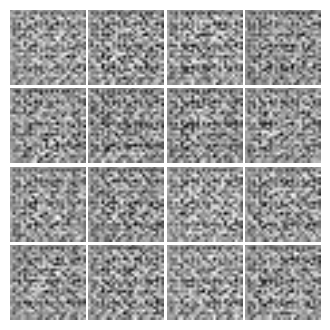

step 100, discriminator loss 0.85784  generator loss 1.39115
step 200, discriminator loss 0.44820  generator loss 2.21131
step 300, discriminator loss 0.84276  generator loss 1.69659
step 400, discriminator loss 0.72615  generator loss 1.95878
step 500, discriminator loss 0.71053  generator loss 1.77434
step 600, discriminator loss 0.71514  generator loss 1.84341
step 700, discriminator loss 0.51880  generator loss 1.86431
step 800, discriminator loss 0.26334  generator loss 2.29687
step 900, discriminator loss 0.22319  generator loss 2.62868
step 1000, discriminator loss 0.18192  generator loss 2.64233


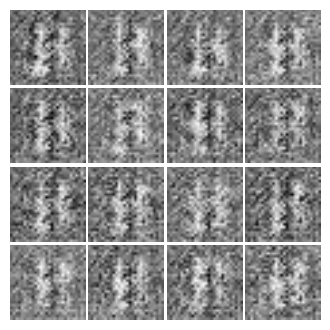

step 2000, discriminator loss 0.24685  generator loss 2.95130


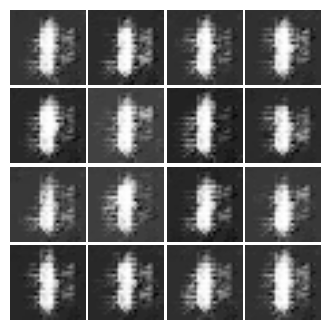

step 3000, discriminator loss 0.05564  generator loss 4.25037
step 4000, discriminator loss 0.04217  generator loss 4.71265


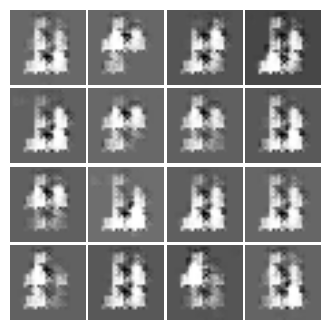

step 5000, discriminator loss 0.22856  generator loss 3.57268
step 6000, discriminator loss 0.12961  generator loss 4.49799


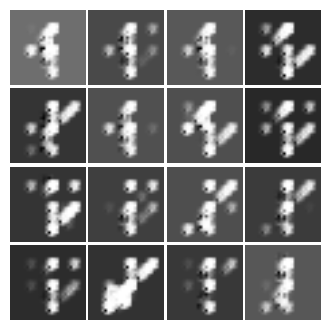

step 7000, discriminator loss 0.04830  generator loss 5.12374
step 8000, discriminator loss 0.01379  generator loss 6.38079


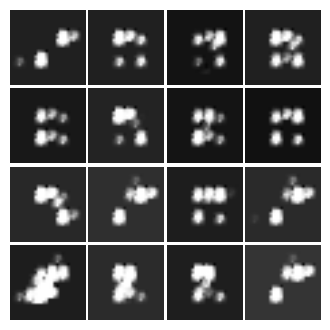

step 9000, discriminator loss 0.00626  generator loss 5.92065
step 10000, discriminator loss 0.05310  generator loss 6.42939


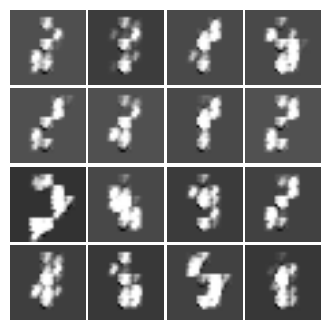

step 11000, discriminator loss 0.01101  generator loss 7.24146
step 12000, discriminator loss 0.00744  generator loss 6.53067


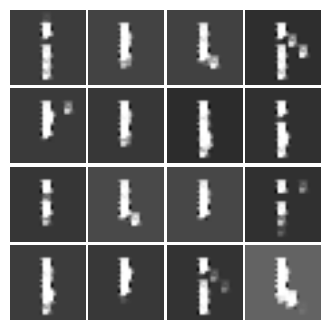

step 13000, discriminator loss 0.01497  generator loss 8.72534
step 14000, discriminator loss 0.05123  generator loss 5.25377


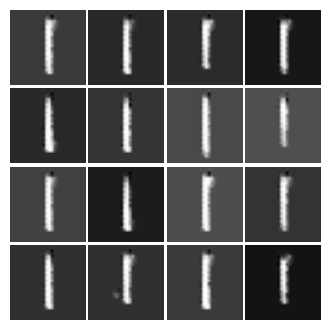

step 15000, discriminator loss 0.00633  generator loss 6.64243
step 16000, discriminator loss 0.00066  generator loss 7.72938


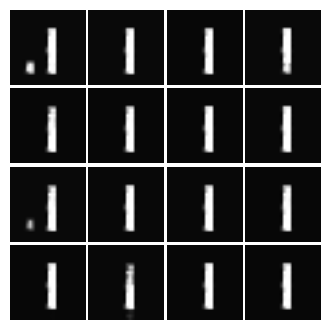

step 17000, discriminator loss 0.00209  generator loss 7.22791
step 18000, discriminator loss 0.00046  generator loss 7.68677


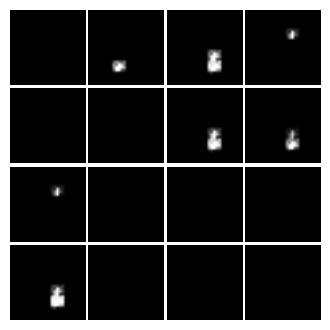

step 19000, discriminator loss 0.00222  generator loss 6.73453
step 20000, discriminator loss 0.00914  generator loss 5.61193


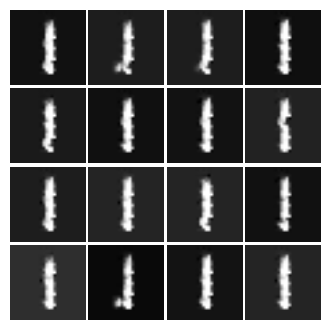

In [9]:
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)
for step in range(20001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict = {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict = {x_g: sample_Z(batch_size, g_dim)})

    if step <= 1000:
        if step % 100 == 0:
            print("step %d, discriminator loss %.5f" % (step, d_loss_train)),
            print(" generator loss %.5f" % (g_loss_train))
        if step % 1000 == 0: 
            g_sample_plot = g_sample.eval(feed_dict = {x_g: sample_Z(16, g_dim)})
            plot(g_sample_plot)
    else:
        if step % 1000 == 0:
            print("step %d, discriminator loss %.5f" % (step, d_loss_train)),
            print(" generator loss %.5f" % (g_loss_train))
        if step % 2000 == 0: 
            g_sample_plot = g_sample.eval(feed_dict = {x_g: sample_Z(16, g_dim)})
            plot(g_sample_plot)



以下是連續 gif 圖，這一連串的訓練時間真的是還滿久的...很有趣的有兩點

1. 只出現了數字 1，沒有其他的數字，怪哉．
2. 到了 step 18000 突然生成式網路就壞掉了，然後又好了．

![gif](https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/images/14_DCGAN/dcgan.gif?raw=true)

## 小結

我們實作了 DCGAN ，以及利用 MNIST 資料來測試它的效果．

效果跟預期有些差異，其中只出現了某一數字，然後在某一時刻生成器發生崩壞．

### 問題

- 尋找生成式網路崩壞還有只出現某一數字的原因．
- 調整生成式網路的層數
- 調整生成式網路各層的 channels


## 學習資源連結

- [DCGAN paper](https://arxiv.org/abs/1511.06434)
- [DCGAN tensorflow example](https://github.com/carpedm20/DCGAN-tensorflow)
- [DCGAN explanation blog post](http://bamos.github.io/2016/08/09/deep-completion/)